In [1]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Load the dataset

In [2]:
import nltk

In [3]:
from nltk.corpus import reuters
from nltk.corpus import stopwords

In [4]:
labels = reuters.categories()
stop_words = stopwords.words('english')

In [5]:
documents = reuters.fileids()
test = [d for d in documents if d.startswith("test/")]
train = [d for d in documents if d.startswith("training/")]

In [6]:
docs = {}
docs["train"] = [reuters.raw(doc_id) for doc_id in train]
docs["test"] = [reuters.raw(doc_id) for doc_id in test]

In [7]:
label_train = [reuters.categories(doc_id) for doc_id in train]
label_test = [reuters.categories(doc_id) for doc_id in test]

## Pick only single label documents.

In [8]:
import pandas as pd
sel = pd.DataFrame(label_train)
one_topic_train = sel[1].isna()
sel = sel[one_topic_train]
label_train = sel[[0]]

In [9]:
sel = pd.DataFrame(label_test)
one_topic_test = sel[1].isna()
sel = sel[one_topic_test]
label_test = sel[[0]]

In [10]:
sel = pd.DataFrame(docs["train"])
sel = sel[one_topic_train]
docs_train = sel[[0]]

In [11]:
sel = pd.DataFrame(docs["test"])
sel = sel[one_topic_test]
docs_test = sel[[0]]

## Pick only the top 10 most frequency labels.

In [12]:
top10_labels = label_train[0].value_counts()[:3].index.to_list()

In [13]:
top10 = label_train[0].isin(top10_labels)
label_train = label_train[top10]
docs_train = docs_train[top10]

In [14]:
top10 = label_test[0].isin(top10_labels)
label_test = label_test[top10]
docs_test = docs_test[top10]

In [15]:
print('documents for training', docs_train.shape[0])
print('documents for testimg', docs_test.shape[0])

documents for training 4689
documents for testimg 1900


# Preprocessing the data

In [16]:
import re
numbers = re.compile(r'(\d+,\d+)|(\s+\d+\s+)'
                         r'|(\d+th)|(\d+am)|(\d+pm)|(\d+)|'
                         r'(\d+pa)|(\d+\s+pa)')
docs_train = [numbers.sub(" ntkn ", line) for line in docs_train[0].to_list()]
docs_test = [numbers.sub(" ntkn ", line) for line in docs_test[0].to_list()]

# Benchmark model

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score

vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(docs_train).toarray()
x_test = vectorizer.transform(docs_test).toarray()

f1 0.97
recall 0.97
precision 0.97
Normalized confusion matrix


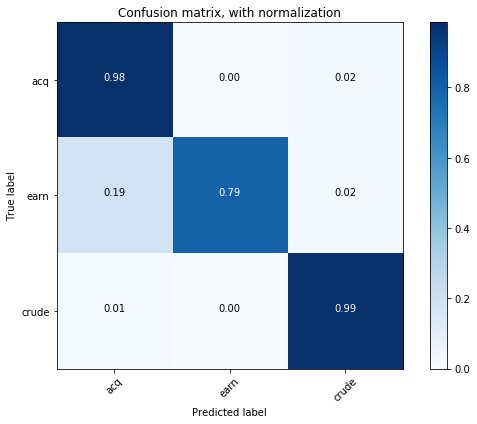

In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np
#m = OneVsRestClassifier(LinearSVC())
m = OneVsRestClassifier(LogisticRegression(solver = 'lbfgs'))
m.fit(x_train, label_train)
pred = m.predict(x_test)

f1 = fbeta_score(y_true=label_test, y_pred=pred, beta=1, average="weighted")
recall = recall_score(y_true=label_test, y_pred=pred, average="weighted")
precision = precision_score(y_true=label_test, y_pred=pred, average="weighted")
print('f1', round(f1,2))
print('recall', round(recall,2))
print('precision', round(precision,2))

classes = list(set(label_train.iloc[:,0].to_list()))
cnf_matrix = confusion_matrix(label_test, pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes = classes, normalize=True, 
                      title='Confusion matrix, with normalization')

# Using feed-forward neural network for classification

In [22]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
label_train_one_hot = lb.fit_transform(label_train[0].to_list())
label_test_one_hot = lb.transform(label_test[0].to_list())

In [23]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(17192,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer = 'rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, label_train_one_hot, epochs=3, batch_size=128, validation_data = (x_test, label_test_one_hot))

Using TensorFlow backend.


Train on 4689 samples, validate on 1900 samples
Epoch 1/3
4689/4689 [==============================] - 4s 847us/step - loss: 0.6297 - accuracy: 0.8729 - val_loss: 0.2554 - val_accuracy: 0.9237
Epoch 2/3
4689/4689 [==============================] - 3s 549us/step - loss: 0.1630 - accuracy: 0.9544 - val_loss: 0.1194 - val_accuracy: 0.9674
Epoch 3/3
4689/4689 [==============================] - 3s 635us/step - loss: 0.0655 - accuracy: 0.9878 - val_loss: 0.0682 - val_accuracy: 0.9811


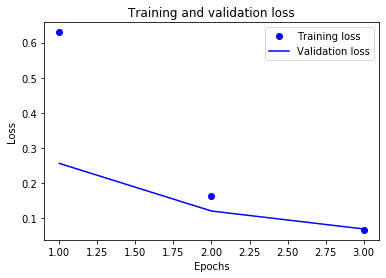

In [24]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

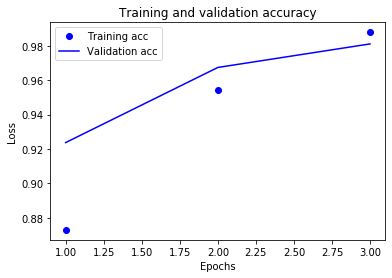

In [25]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

f1 0.98
recall 0.98
precision 0.98
Normalized confusion matrix


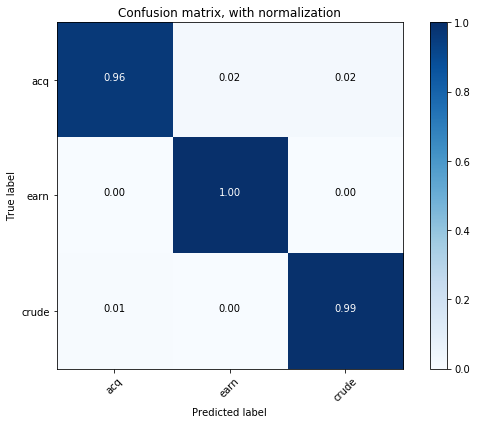

In [26]:
pred = model.predict(x_test)
pred = lb.inverse_transform(pred)

f1 = fbeta_score(y_true=label_test, y_pred=pred, beta=1, average="weighted")
recall = recall_score(y_true=label_test, y_pred=pred, average="weighted")
precision = precision_score(y_true=label_test, y_pred=pred, average="weighted")
print('f1', round(f1,2))
print('recall', round(recall,2))
print('precision', round(precision,2))

cnf_matrix = confusion_matrix(pred, label_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes = classes, normalize=True, 
                      title='Confusion matrix, with normalization')

# Using neural networks with word embeddings for classification task

In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 2000  
max_words = 10000  
input_dim = 8

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(docs_train)
sequences = tokenizer.texts_to_sequences(docs_train)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(label_train[0].to_list())
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

x_train = data
y_train = labels

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(docs_test)
sequences = tokenizer.texts_to_sequences(docs_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(label_test[0].to_list())
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

x_val = data
y_val = labels

Found 18113 unique tokens.
Shape of data tensor: (4689, 2000)
Shape of label tensor: (4689,)
Found 10608 unique tokens.
Shape of data tensor: (1900, 2000)
Shape of label tensor: (1900,)


In [29]:
lb = LabelBinarizer()
label_train_one_hot = lb.fit_transform(y_train)
label_test_one_hot = lb.transform(y_val)

In [30]:
m = OneVsRestClassifier(LogisticRegression(solver = 'lbfgs', max_iter = 100))
m.fit(x_train, label_train)
pred = m.predict(x_val)

f1 = fbeta_score(y_true=label_test, y_pred=pred, beta=1, average="weighted")
recall = recall_score(y_true=label_test, y_pred=pred, average="weighted")
precision = precision_score(y_true=label_test, y_pred=pred, average="weighted")
print('f1', round(f1,2))
print('recall', round(recall,2))
print('precision', round(precision,2))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


f1 0.45
recall 0.46
precision 0.53


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [31]:
import keras
keras.backend.clear_session()

In [33]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(2000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer = 'rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, label_train_one_hot, epochs=10, batch_size=128, validation_data = (x_val, label_test_one_hot))

Train on 4689 samples, validate on 1900 samples
Epoch 1/10
4689/4689 [==============================] - 1s 300us/step - loss: 49.7860 - accuracy: 0.5383 - val_loss: 23.3734 - val_accuracy: 0.6468
Epoch 2/10
4689/4689 [==============================] - 1s 115us/step - loss: 12.7434 - accuracy: 0.6748 - val_loss: 18.3459 - val_accuracy: 0.6616
Epoch 3/10
4689/4689 [==============================] - 1s 123us/step - loss: 5.7816 - accuracy: 0.7469 - val_loss: 21.5612 - val_accuracy: 0.6474
Epoch 4/10
4689/4689 [==============================] - 1s 118us/step - loss: 3.4247 - accuracy: 0.8015 - val_loss: 15.2907 - val_accuracy: 0.6726
Epoch 5/10
4689/4689 [==============================] - 1s 138us/step - loss: 2.2552 - accuracy: 0.8345 - val_loss: 14.4690 - val_accuracy: 0.6653
Epoch 6/10
4689/4689 [==============================] - 1s 115us/step - loss: 1.7851 - accuracy: 0.8556 - val_loss: 16.1339 - val_accuracy: 0.6868
Epoch 7/10
4689/4689 [==============================] - 1s 134us/ste

In [34]:
pred = model.predict(x_val)
pred = lb.inverse_transform(pred)

f1 = fbeta_score(y_true=label_test, y_pred=pred, beta=1, average="weighted")
recall = recall_score(y_true=label_test, y_pred=pred, average="weighted")
precision = precision_score(y_true=label_test, y_pred=pred, average="weighted")
print('f1', round(f1,2))
print('recall', round(recall,2))
print('precision', round(precision,2))

f1 0.69
recall 0.7
precision 0.69


In [35]:
keras.backend.clear_session()

In [37]:
from keras.layers import Embedding, Flatten
model = models.Sequential()
model.add(Embedding(max_words, 100, input_length=maxlen))
model.add(Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer = 'rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, label_train_one_hot,
                    epochs=4,
                    batch_size=32,
                    validation_data=(x_val, label_test_one_hot))

pred = model.predict(x_val)
pred = lb.inverse_transform(pred)

f1 = fbeta_score(y_true=label_test, y_pred=pred, beta=1, average="weighted")
recall = recall_score(y_true=label_test, y_pred=pred, average="weighted")
precision = precision_score(y_true=label_test, y_pred=pred, average="weighted")
print('f1', round(f1,2))
print('recall', round(recall,2))
print('precision', round(precision,2))

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4689 samples, validate on 1900 samples
Epoch 1/4
4689/4689 [==============================] - 29s 6ms/step - loss: 1.2431 - accuracy: 0.5728 - val_loss: 0.8969 - val_accuracy: 0.5700
Epoch 2/4
4689/4689 [==============================] - 28s 6ms/step - loss: 0.7970 - accuracy: 0.6317 - val_loss: 0.9201 - val_accuracy: 0.6089
Epoch 3/4
4689/4689 [==============================] - 27s 6ms/step - loss: 0.3381 - accuracy: 0.8923 - val_loss: 1.9078 - val_accuracy: 0.6068
Epoch 4/4
4689/4689 [==============================] - 27s 6ms/step - loss: 0.1506 - accuracy: 0.9480 - val_loss: 3.5532 - val_accuracy: 0.5895
f1 0.47
recall 0.59
precision 0.62


In [110]:
keras.backend.clear_session()

In [39]:
from keras.layers import LSTM
model = models.Sequential()
model.add(Embedding(max_words, 100, input_length=maxlen))
model.add(layers.LSTM(32))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer = 'rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, label_train_one_hot,
                    epochs=1,
                    batch_size=31,
                    validation_data=(x_val, label_test_one_hot))

pred = model.predict(x_val)
pred = lb.inverse_transform(pred)

f1 = fbeta_score(y_true=label_test, y_pred=pred, beta=1, average="weighted")
recall = recall_score(y_true=label_test, y_pred=pred, average="weighted")
precision = precision_score(y_true=label_test, y_pred=pred, average="weighted")
print('f1', round(f1,2))
print('recall', round(recall,2))
print('precision', round(precision,2))

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4689 samples, validate on 1900 samples
Epoch 1/1
4689/4689 [==============================] - 1305s 278ms/step - loss: 0.4549 - accuracy: 0.8584 - val_loss: 1.1822 - val_accuracy: 0.6432
f1 0.59
recall 0.64
precision 0.6


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
keras.backend.clear_session()

In [41]:
model = models.Sequential()
model.add(Embedding(max_words, 100, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation = 'relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation = 'relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer = 'rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, label_train_one_hot,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, label_test_one_hot))

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4689 samples, validate on 1900 samples
Epoch 1/10
4689/4689 [==============================] - 34s 7ms/step - loss: 0.3298 - accuracy: 0.8708 - val_loss: 1.7830 - val_accuracy: 0.5674
Epoch 2/10
4689/4689 [==============================] - 33s 7ms/step - loss: 0.0742 - accuracy: 0.9785 - val_loss: 3.8127 - val_accuracy: 0.5711
Epoch 3/10
4689/4689 [==============================] - 32s 7ms/step - loss: 0.0234 - accuracy: 0.9934 - val_loss: 3.5811 - val_accuracy: 0.5774
Epoch 4/10
4689/4689 [==============================] - 32s 7ms/step - loss: 0.0122 - accuracy: 0.9968 - val_loss: 4.2059 - val_accuracy: 0.5721
Epoch 5/10
4689/4689 [==============================] - 33s 7ms/step - loss: 0.0079 - accuracy: 0.9979 - val_loss: 4.5775 - val_accuracy: 0.5679
Epoch 6/10
4689/4689 [==============================] - 33s 7ms/step - loss: 0.0060 - accuracy: 0.9985 - val_loss: 5.4320 - val_accuracy: 0.5747
Epoch 7/10
4689/4689 [==============================] - 33s 7ms/step - loss: 0.005

In [42]:
pred = model.predict(x_val)
pred = lb.inverse_transform(pred)

f1 = fbeta_score(y_true=label_test, y_pred=pred, beta=1, average="weighted")
recall = recall_score(y_true=label_test, y_pred=pred, average="weighted")
precision = precision_score(y_true=label_test, y_pred=pred, average="weighted")
print('f1', round(f1,2))
print('recall', round(recall,2))
print('precision', round(precision,2))

f1 0.47
recall 0.58
precision 0.53
